In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
DATA_DIR = '/Users/victor/code/afallo/brain_tumor_detection_project/raw_data/segmentation/kaggle_3m'

## To DF + Balancing des classes

In [3]:
def create_diagnosed_dataframe(data_dir):
    data = []

    print("🕵️‍♂️ Analyse et vérification des fichiers en cours...")

    for dirname, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if 'mask' in filename and filename.endswith('.tif'):

                mask_path = os.path.join(dirname, filename)
                image_filename = filename.replace('_mask', '')
                image_path = os.path.join(dirname, image_filename)

                # 1. Vérification d'intégrité : L'image source existe-t-elle ?
                if os.path.exists(image_path):

                    # 2. Vérification de contenu : Le masque est-il vide ?
                    # On lit le masque en niveau de gris (0 = noir, 255 = blanc)
                    try:
                        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                        # Si la valeur max est > 0, c'est qu'il y a une tumeur (du blanc)
                        has_tumor = 1 if np.max(mask_img) > 0 else 0

                        data.append({
                            'image_path': image_path,
                            'mask_path': mask_path,
                            'has_tumor': has_tumor
                        })
                    except Exception as e:
                        print(f"⚠️ Fichier corrompu ignoré : {filename} ({e})")

    df = pd.DataFrame(data)
    return df

# Exécution
df = create_diagnosed_dataframe(DATA_DIR)

🕵️‍♂️ Analyse et vérification des fichiers en cours...


In [4]:
def balance_dataset(df):
    # 1. On sépare les deux groupes
    df_tumor = df[df['has_tumor'] == 1]
    df_healthy = df[df['has_tumor'] == 0]

    print(f"Original -> Tumeurs: {len(df_tumor)} | Sains: {len(df_healthy)}")

    # 2. On décide combien de sains on garde
    # Pour un U-Net, un ratio 50/50 ou 60/40 est souvent idéal.
    # Ici, on garde autant de sains que de tumeurs (ratio 1:1)
    n_samples = len(df_tumor)

    # Si on a moins de sains que de tumeurs (rare), on prend tout
    if len(df_healthy) > n_samples:
        df_healthy_sampled = df_healthy.sample(n=n_samples, random_state=42)
    else:
        df_healthy_sampled = df_healthy

    # 3. On recombine et on mélange
    df_balanced = pd.concat([df_tumor, df_healthy_sampled])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_balanced

# --- EXÉCUTION ---
df_final = balance_dataset(df)

print(f"\n✅ Dataset Équilibré Prêt !")
print(f"Taille finale : {len(df_final)} images")
print(f"Répartition : 50% Tumeurs / 50% Sains (environ)")

Original -> Tumeurs: 1373 | Sains: 2556

✅ Dataset Équilibré Prêt !
Taille finale : 2746 images
Répartition : 50% Tumeurs / 50% Sains (environ)


In [5]:
df_final

,image_path,mask_path,has_tumor
0,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1
1,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
2,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
3,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
4,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
...,...,...,...
2741,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
2742,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1
2743,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1
2744,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1


## Vérification Mask to tumor & équilibre

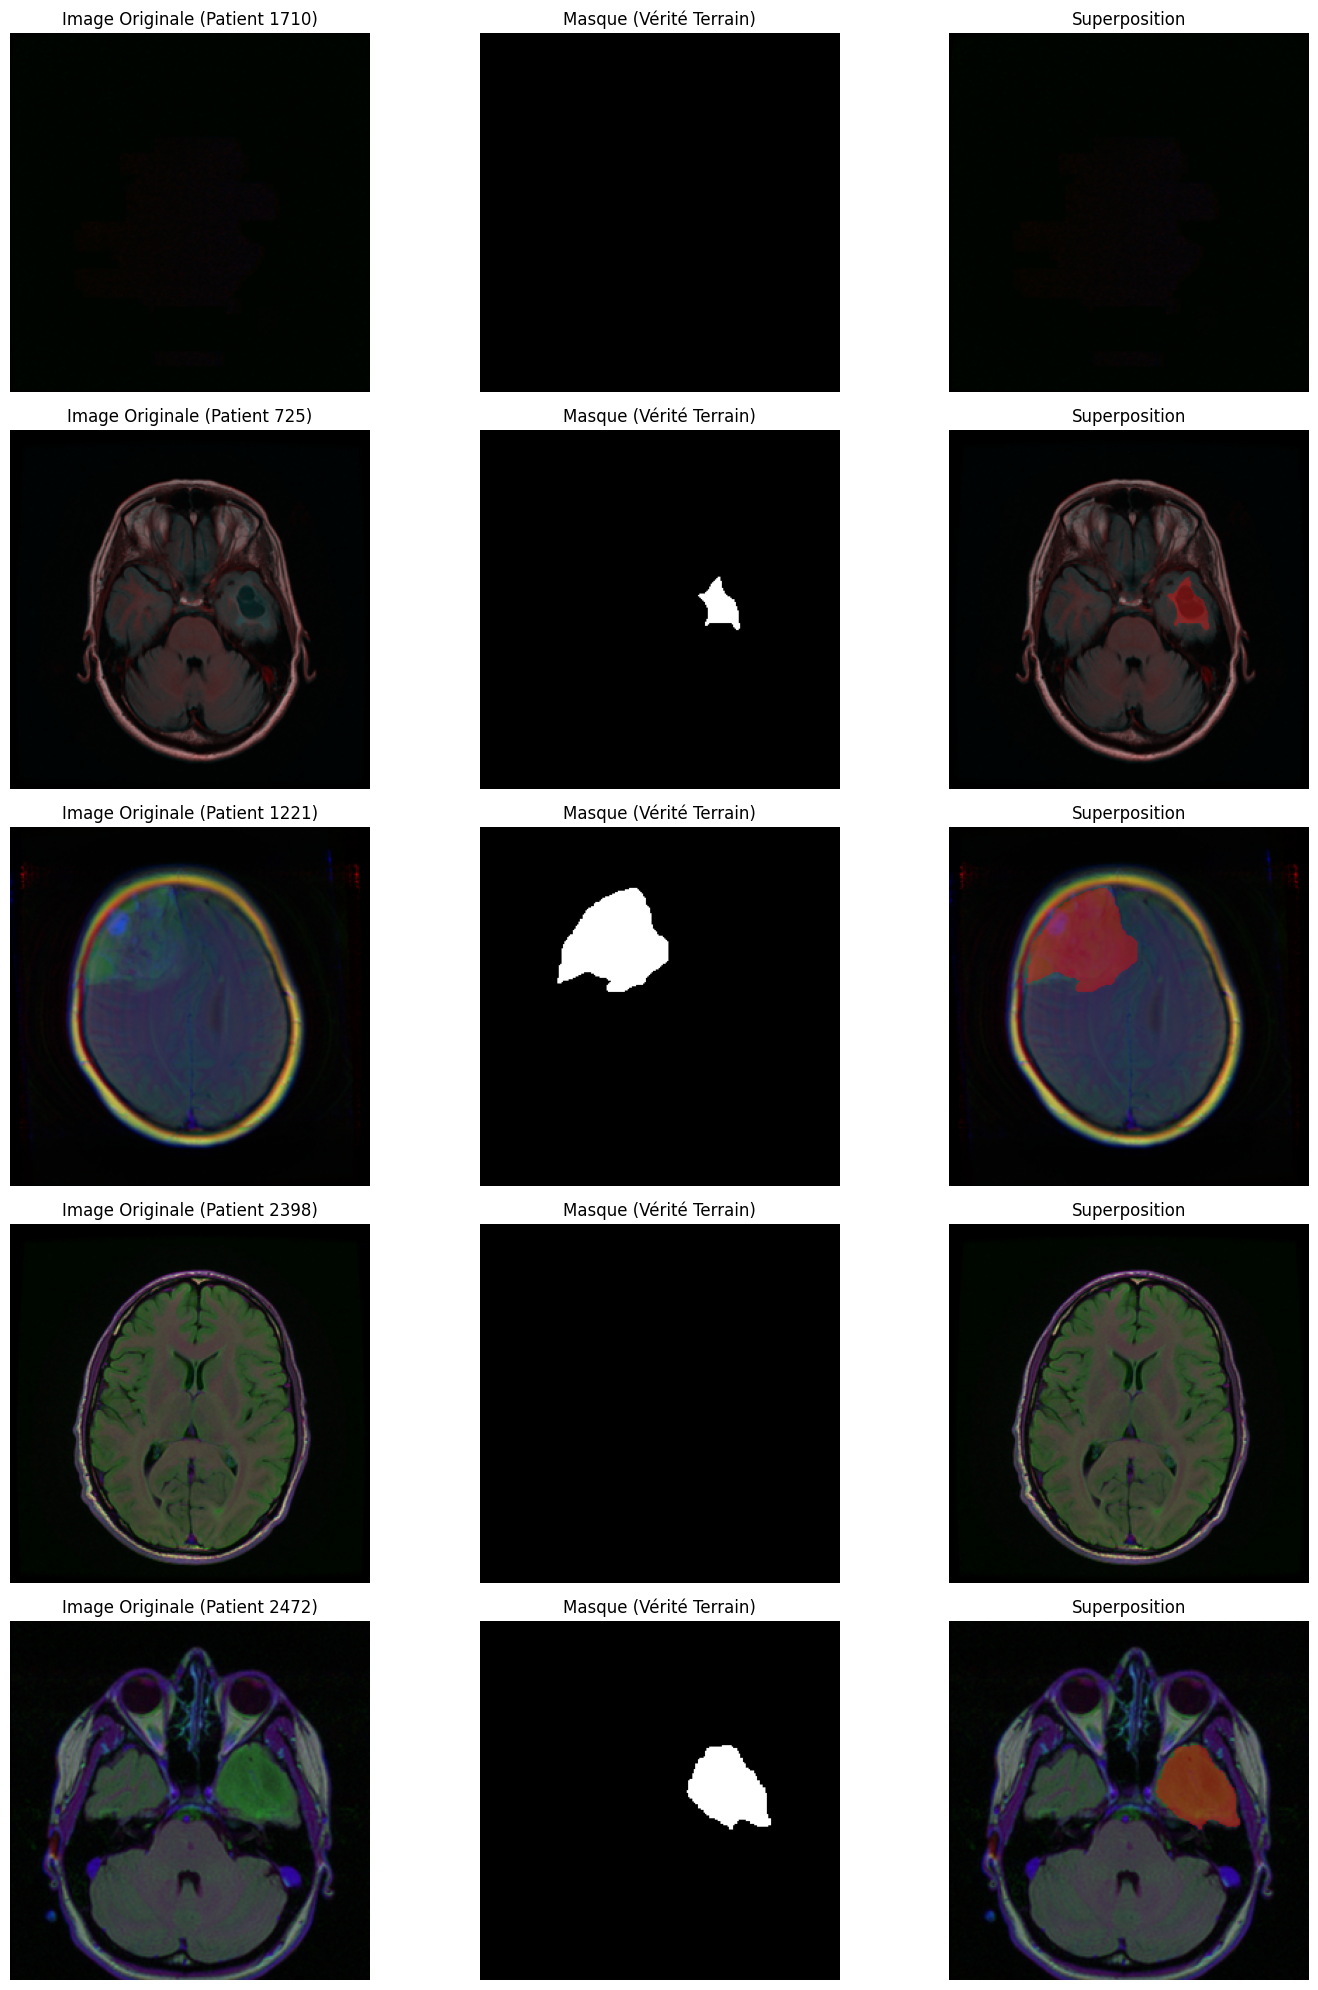

In [6]:
def visualize_data(df, n_samples=5):
    plt.figure(figsize=(15, n_samples * 4))

    # On prend n_samples indices au hasard dans le dataframe
    indices = random.sample(range(len(df)), n_samples)

    for i, idx in enumerate(indices):
        img_path = df.iloc[idx]['image_path']
        mask_path = df.iloc[idx]['mask_path']

        # Lecture des images
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Conversion BGR -> RGB pour l'affichage correct

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # --- Création de la superposition (Overlay) ---
        # On crée une copie de l'image pour dessiner dessus
        overlay = img.copy()

        # On colorie en rouge là où le masque est blanc (tumeur)
        # mask > 0 renvoie les pixels de la tumeur
        overlay[mask > 0] = [255, 0, 0] # Rouge pur

        # On applique la transparence (alpha blending)
        # image_finale = alpha * overlay + (1-alpha) * image_originale
        final_img = cv2.addWeighted(overlay, 0.4, img, 0.6, 0)

        # --- Affichage ---
        # 1. Image Originale
        plt.subplot(n_samples, 3, i*3 + 1)
        plt.imshow(img)
        plt.title(f"Image Originale (Patient {idx})")
        plt.axis('off')

        # 2. Masque
        plt.subplot(n_samples, 3, i*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Masque (Vérité Terrain)")
        plt.axis('off')

        # 3. Superposition
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(final_img)
        plt.title("Superposition")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Lancer la visualisation
visualize_data(df_final)

--- Répartition exacte ---
has_tumor
1    1373
0    1373
Name: count, dtype: int64

--- En pourcentage ---
has_tumor
1    50.0
0    50.0
Name: proportion, dtype: float64


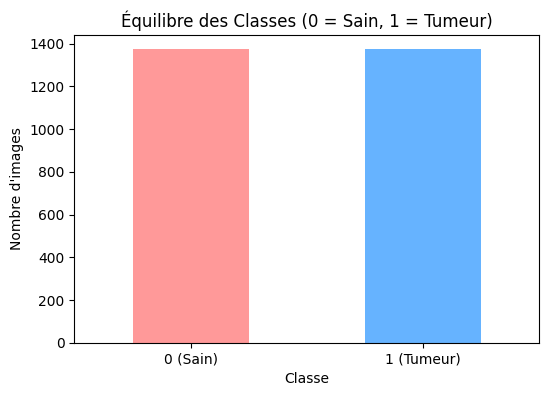

In [7]:
# 1. Compter les valeurs exactes
counts = df_final['has_tumor'].value_counts()

print("--- Répartition exacte ---")
print(counts)

# 2. Vérifier les pourcentages
percentages = df_final['has_tumor'].value_counts(normalize=True) * 100
print("\n--- En pourcentage ---")
print(percentages)

# 3. Visualisation graphique
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color=['#ff9999', '#66b3ff'])
plt.title('Équilibre des Classes (0 = Sain, 1 = Tumeur)')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'images')
plt.xticks(ticks=[0, 1], labels=['0 (Sain)', '1 (Tumeur)'], rotation=0)
plt.show()

## Spliting des datas

In [8]:
# --- 1. PARAMÈTRES GLOBAUX ---
IMG_SIZE = 256      # On redimensionne tout en 256x256
BATCH_SIZE = 32     # Le modèle verra 32 images à la fois
EPOCHS = 40         # On entraînera potentiellement sur 40 tours

# --- 2. SÉPARATION DES DONNÉES (TRAIN / VAL / TEST) ---
# On divise d'abord en : 85% (Train+Val) et 15% (Test final)
train_val_df, test_df = train_test_split(df_final, test_size=0.15, random_state=42)

# On recoupe les 85% restants en : 85% Train et 15% Validation
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42)

print(f"📊 Volume des données :")
print(f"Train      : {len(train_df)} images (Pour apprendre)")
print(f"Validation : {len(val_df)} images (Pour s'évaluer en cours de route)")
print(f"Test       : {len(test_df)} images (Pour l'examen final)")

# --- 3. CRÉATION DU GÉNÉRATEUR PERSONNALISÉ ---
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, img_size=256, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end() # Mélange au démarrage

    def __len__(self):
        # Nombre de "paquets" (batchs) par époque
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        # Sélectionne les indices pour ce batch
        indexes = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Initialisation des tableaux vides
        X = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype=np.float32)

        # Chargement des images et masques
        for i, idx in enumerate(indexes):
            # Chemins
            img_path = self.df.iloc[idx]['image_path']
            mask_path = self.df.iloc[idx]['mask_path']

            # Traitement IMAGE
            img = cv2.imread(img_path)
            img = cv2.resize(img, (self.img_size, self.img_size)) # Redimensionner
            img = img / 255.0  # Normalisation (0-1)
            X[i] = img

            # Traitement MASQUE
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            # Le masque doit être binaire (0 ou 1), pas (0 à 255)
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1) # Ajouter la dimension de canal (256,256,1)
            y[i] = mask

        return X, y

    def on_epoch_end(self):
        # Mélange les indices après chaque tour complet (époque)
        if self.shuffle:
            np.random.shuffle(self.indices)

# --- 4. INSTANCIATION DES GÉNÉRATEURS ---
train_generator = DataGenerator(train_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_generator = DataGenerator(val_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
test_generator = DataGenerator(test_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False)

print("\n✅ Générateurs prêts ! Prêts à nourrir le modèle.")

📊 Volume des données :
Train      : 1983 images (Pour apprendre)
Validation : 351 images (Pour s'évaluer en cours de route)
Test       : 412 images (Pour l'examen final)

✅ Générateurs prêts ! Prêts à nourrir le modèle.


In [9]:
# On tire un seul batch pour voir
X_sample, y_sample = train_generator[0]
print(f"Format des Images (X) : {X_sample.shape}") # Doit être (32, 256, 256, 3)
print(f"Format des Masques (y): {y_sample.shape}") # Doit être (32, 256, 256, 1)

Format des Images (X) : (32, 256, 256, 3)
Format des Masques (y): (32, 256, 256, 1)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [15]:
# --- 1. DÉFINITION DES MÉTRIQUES (DICE) ---

def dice_coef(y_true, y_pred):
    # On aplatit les images pour comparer pixel par pixel
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    # Formule du Dice : (2 * Intersection) / (Total pixels prédits + Total pixels réels)
    # Le smooth=1 évite la division par zéro
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [16]:
def baseline_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    model = Sequential()

    # Entrée
    model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))

    # --- ENCODEUR (Compression) ---
    # On réduit simplement la taille pour capter le contexte
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2))) # -> 128x128

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2))) # -> 64x64

    # --- BOTTLENECK ---
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

    # --- DÉCODEUR (Reconstruction) ---
    # On regonfle sans aide (pas de skip connections)
    model.add(UpSampling2D((2, 2))) # -> 128x128
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

    model.add(UpSampling2D((2, 2))) # -> 256x256
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

    # --- SORTIE ---
    model.add(Conv2D(1, (1, 1), activation='sigmoid')) # Probabilité 0-1

    # Compilation (Mêmes métriques pour comparaison loyale)
    model.compile(optimizer='adam',
                  loss=dice_coef_loss,  # On garde la même loss custom
                  metrics=['accuracy', dice_coef])

    return model

# Instanciation de la Baseline
model_baseline = baseline_model(IMG_SIZE, IMG_SIZE, 3)
model_baseline.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,537 (724.75 KB)

 Trainable params: 185,537 (724.75 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# --- 1. CONFIGURATION DES OUTILS DE CONTRÔLE ---
callbacks = [
    # Arrête l'entraînement si la "val_loss" ne descend plus après 5 époques
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),

    # Réduit la vitesse d'apprentissage si on bloque sur un plateau
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1),

    # Sauvegarde le meilleur modèle dans un fichier
    ModelCheckpoint('baseline_brain_tumor.keras', monitor='val_dice_coef', save_best_only=True, mode='max', verbose=1)
]

# --- 2. LANCEMENT DE L'ENTRAÎNEMENT ---
print("🏁 Début de l'entraînement du Baseline Model...")

history_baseline = model_baseline.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # On met 30, mais le EarlyStopping arrêtera sûrement avant
    callbacks=callbacks,
    verbose=1
)

# --- 3. VISUALISATION DES PERFORMANCES ---
def plot_history(history, title="Baseline Model Performance"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Graphique de la LOSS (Erreur)
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss (Plus bas est mieux)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Dice Loss')
    ax1.legend()
    ax1.grid(True)

    # Graphique du DICE SCORE (Précision)
    ax2.plot(history.history['dice_coef'], label='Train Dice')
    ax2.plot(history.history['val_dice_coef'], label='Validation Dice')
    ax2.set_title(f'{title} - Dice Score (Plus haut est mieux)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Dice Coefficient')
    ax2.legend()
    ax2.grid(True)

    plt.show()

plot_history(history_baseline)

🏁 Début de l'entraînement du Baseline Model...
Epoch 1/30


2025-12-02 17:37:30.978629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 7/61 ━━━━━━━━━━━━━━━━━━━━ 6:13 7s/step - accuracy: 0.0472 - dice_coef: 0.0350 - loss: 0.9650

KeyboardInterrupt: 